# Exploring Income Factors

I want to the most important income determinant factors for Income in Amercia, controlling for Age.

This project is a large undertaking for a single computer, and as such will be split into 3 parts. In the first part, I will import and combine the data. The second part will pertain to my data cleaning and feature selection. Finally, I will perform descriptive modeling on the most important factors using linear mixed effect modeling.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import savReaderWriter

# Part 3: Descriptive Modeling

Now that I have selected the 4 most important features, I want to perform descriptive modeling to better understand what interaction they have with income. 


As stated before, I will be using Linear Mixed Effect (LME) modeling to predict the relationship between income and education level, hours worked, weeks worked, and if the person works a part time job, controlling for age. This will allow to control for the the most important factors of income, without the noise that the age variable creates. Since people just starting their careers tend to have have similar income values to people in the twilight of their careers, reducing that noise will be valuable.

The first thing I must do is import my data.

# Importing

Get the data exported at the end of Part 2.  The 4 feature set as well as the Income, and the original data set with only pertinent features, to get age or any other features as desired.

In [2]:
# get feature data set
work_ft = pd.read_csv('C:\\Code\\SSP\\workft.csv')
old_ind = work_ft['Unnamed: 0']
work_ft = work_ft.drop('Unnamed: 0',1)
print(work_ft.shape)
work_ft.head()

(8929, 5)


,HRS1,PARTFULL_2.0,EDUC,WEEKSWRK,Target
0,42.0,0,12.0,52.0,160.436903
1,5.0,1,18.0,52.0,30.594117
2,0.0,0,10.0,52.0,105.427700
3,42.0,0,13.0,52.0,113.446022
4,40.0,0,18.0,52.0,132.476413


In [3]:
work_ft.columns = ['Hours','Part','Educ','Weeks','Target']
work_ft.head()

,Hours,Part,Educ,Weeks,Target
0,42.0,0,12.0,52.0,160.436903
1,5.0,1,18.0,52.0,30.594117
2,0.0,0,10.0,52.0,105.427700
3,42.0,0,13.0,52.0,113.446022
4,40.0,0,18.0,52.0,132.476413


In [4]:
# get total feature set with only pertinent indexes
work_all = pd.read_csv('C:\\Code\\SSP\\workall.csv')
old_ind_all = work_all['Unnamed: 0']
work_all = work_all.drop('Unnamed: 0',1)
print(work_all.shape)

(8929, 416)


In [5]:
# add age to feature index to allow it to be controlled for in the mixed effect model
work_ft['Age'] = work_all['AGE']

In [6]:
work_ft.head()

,Hours,Part,Educ,Weeks,Target,Age
0,42.0,0,12.0,52.0,160.436903,61.0
1,5.0,1,18.0,52.0,30.594117,55.0
2,0.0,0,10.0,52.0,105.427700,76.0
3,42.0,0,13.0,52.0,113.446022,33.0
4,40.0,0,18.0,52.0,132.476413,31.0


# Calculate ICC

Before I begin Linear Mixed Effect modeling, I must make sure that my controlled group, respondant age, has a sufficient Interclass Correlation(ICC). This means that respondant's within the same group are more similar to each other than any other member of the data set at large. An ICC of 5% or higher is usually expected. 

Even though I only need to know that the ICC of age is significantly high, I will calculate the ICC of all my features.

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

In [8]:
# Function to calculate the intraclass correlation
def ICC(fittedmodel):
    between_var= fittedmodel.cov_re.iloc[0,0]
    resid=fittedmodel.scale
    icc=between_var/(between_var+resid)
    return icc

In [9]:
columns = list(work_ft.columns)
columns.remove('Target')
iccs = pd.DataFrame(index=columns)
icc_list = []
for feat in columns:
    print('{} ICC Model...\n'.format(feat))
    model = smf.mixedlm("Target ~ 1",data=work_ft,groups=work_ft[feat])
    result = model.fit(method='nm',maxiter=200, full_output=True)
    print(result.summary())
    print("done!")
    print('The Intraclass Correlation is for {} Group is: {}\n\n'.format(feat,ICC(result)))
    icc_list.append(ICC(result))

iccs['ICC'] = icc_list

Hours ICC Model...

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       86      Scale:              2246.9762  
Min. group size:  1       Likelihood:         -47228.4777
Max. group size:  2545    Converged:          Yes        
Mean group size:  103.8                                  
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   116.797    3.464 33.715 0.000 110.007 123.587
Group Var   862.160    3.328                             

done!
The Intraclass Correlation is for Hours Group is: 0.2772989362025546


Part ICC Model...

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       2       Scale: 

In [10]:
iccs

,ICC
Hours,0.277299
Part,0.419952
Educ,0.228638
Weeks,0.232246
Age,0.202126


So, when predicting income, people of the same age are more than 20% more similar to each other than any other member of the data set. This is certainly enough to warrent building a LME model this this data

# Modeling with Mixed Effects

Mixed Effect models are made up of both 'fixed' and 'random' effects. Fixed effects are the trends that the entire data set follows. Every parameter will have fixed effects. Random effect are the trends that only effect members of the same group, in this case people of the same age.

Not every parameter will have random effects, and finding which parameter should have random effects and which should not is one of the most important and difficult parts of Mixed Effect modeling.

# Modeling with Mixed Effects

Mixed Effect models are made up of both 'fixed' and 'random' effects. Fixed effects are the trends that the entire data set follows and every parameter will have fixed effects (the intercept may be fixed of random). Random effect are the trends that only effect members of the same group, in this case people of the same age; not every parameter will have random effects, and finding which parameter should have random effects and which should not is one of the most important parts of ME modelings.

A LME can be thought of building 2 different layers of models, a standard linear regressive model that fits the trends of the overall parameters, and then a set of models describing how each of the groups are uniquely affected by each of the parameters. 

The top layer linear formula will look like this:

$$\sqrt{Income} = intercept + A*education + B*hours + C*weeks + D*ifPart$$

What I need to decide is which oh each of these features will have random effects. The random effects are the components of the model that model the different way that people of different ages are affected by each component.

With 5 different components that can have random effects of not (including the intercept), this leads to 31 different configurations of random effects that need to be tested. The best one will be kept and used as my final model: 
1. Random Intercept, Random Education, Hours, Weeks, and Part-Time slopes
2. Random Intercept, Random Education, Hours, and Weeks Slope
3. Random Intercept, Random Education, Hours, and Part-Time slopes
4. Random Intercept, Random Education, Weeks, and Part-Time slopes
5. Random Intercept, Random Hours, Weeks, and Part-Time slopes
6. Random Intercept, Random Education and Hours slopes
7. Random Intercept, Random Education and Weeks slopes
8. Random Intercept, Random Education and Part-Time slopes
9. Random Intercept, Random Hours and Weeks slopes
10. Random Intercept, Random Hours and Part-Time slopes
11. Random Intercept, Random Weeks and Part-Time slopes
12. Random Intercept, Random Education
13. Random Intercept, Random Hours
14. Random Intercept, Random Weeks
15. Random Intercept, Random Part-Time
16. Random Intercept, Fixed slopes
17. Fixed Intercept, Random Education, Hours, Weeks, and Part-Time slopes
18. Fixed Intercept, Random Education, Hours, and Weeks Slope
19. Fixed Intercept, Random Education, Hours, and Part-Time slopes
20. Fixed Intercept, Random Education, Weeks, and Part-Time slopes
21. Fixed Intercept, Random Hours, Weeks, and Part-Time slopes
22. Fixed Intercept, Random Education and Hours slopes
23. Fixed Intercept, Random Education and Weeks slopes
24. Fixed Intercept, Random Education and Part-Time slopes
25. Fixed Intercept, Random Hours and Weeks slopes
26. Fixed Intercept, Random Hours and Part-Time slopes
27. Fixed Intercept, Random Weeks and Part-Time slopes
28. Fixed Intercept, Random Education
29. Fixed Intercept, Random Hours
30. Fixed Intercept, Random Weeks
31. Fixed Intercept, Random Part-Time

# Running Different Random Effect Configurations

There are a lot of configurations to test.  The only way know which one is better is run the model with that random effect configuartion, then compare them with a likelihood test. Now to run them.

## 1. Random Intercept, Randam All Slopes

This model configuration did not converge, I will comment it out.

In [11]:
#print('Running...')
#rirehwt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Educ + Hours + Weeks + Part")
#rirehwt_result = rirehwt_model.fit(method='nm', maxiter=200, full_output=True)
#print(rirehwt_result.summary())
#print("done!")

## 2. Random Intercept, Random Education, Hours, and Weeks

This model configuration did not converge, I will comment it out.

In [12]:
#print('Running...')
#rirehw_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Educ + Hours + Weeks")
#rirehw_result = rirehw_model.fit(method='nm', maxiter=200, full_output=True)
#print(rirehw_result.summary())
#print("done!")

## 3. Random Intercept, Random Education, Hours, and Part-Time

This model configuration did not converge, I will comment it out.

In [13]:
#print('Running...')
#rireht_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Educ + Hours + Part")
#rireht_result = rireht_model.fit(method='nm', maxiter=200, full_output=True)
#print(rireht_result.summary())
#print("done!")

## 4. Random Intercept, Random Education, Weeks, and Part-Time

This model configuration did not converge, I will comment it out.

In [14]:
#print('Running...')
#rirewt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Educ + Weeks + Part")
#rirewt_result = rirewt_model.fit(method='nm', maxiter=200, full_output=True)
#print(rirewt_result.summary())
#print("done!")

## 5. Random Intercept, Random Hours, Weeks, and Part-Time

This model configuration did not converge, I will comment it out.

In [15]:
#print('Running...')
#rirhwt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Hours + Weeks + Part")
#rirhwt_result = rirhwt_model.fit(method='nm', maxiter=200, full_output=True)
#print(rirhwt_result.summary())
#print("done!")

## 6. Random Intercept, Random Education and Hours

This model configuration did not converge, I will comment it out.

In [16]:
#print('Running...')
#rireh_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Educ + Hours")
#rireh_result = rireh_model.fit(method='nm', maxiter=200, full_output=True)
#print(rireh_result.summary())
#print("done!")

## 7. Random Intercept, Random Education and Weeks

In [17]:
print('Running...')
rirew_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Educ + Weeks")
rirew_result = rirew_model.fit(method='nm', maxiter=200, full_output=True)
print(rirew_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1640.4244  
Min. group size:     1         Likelihood:           -45803.3671
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          14.696    2.596   5.660 0.000   9.608  19.785
Educ                5.144    0.206  24.910 0.000   4.739   5.548
Hours               0.544    0.025  21.631 0.000   0.495   0.594
Weeks               0.633    0.031  20.740 0.000   0.573   0.693
Part              -38.064    1.238 -30.750 0.000 -40.490 -35.638
Group Var           6.533    1.712     

## 8. Random Intercept, Random Education and Part-Time

In [18]:
print('Running...')
riret_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Educ + Part")
riret_result = riret_model.fit(method='nm', maxiter=200, full_output=True)
print(riret_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1626.4969  
Min. group size:    1         Likelihood:           -45772.9253
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         16.118    2.685   6.004 0.000  10.856  21.380
Educ               5.068    0.222  22.866 0.000   4.634   5.503
Hours              0.540    0.025  21.529 0.000   0.490   0.589
Weeks              0.624    0.030  21.122 0.000   0.566   0.682
Part             -40.326    1.712 -23.557 0.000 -43.681 -36.971
Group Var         31.100    1.626                    

## 9. Random Intercept, Random Hours and Weeks

In [19]:
print('Running...')
rirhw_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Hours + Weeks")
rirhw_result = rirhw_model.fit(method='nm', maxiter=200, full_output=True)
print(rirhw_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1644.0798  
Min. group size:     1         Likelihood:           -45860.1354
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          12.372    2.769   4.468 0.000   6.944  17.800
Educ                5.243    0.157  33.294 0.000   4.934   5.552
Hours               0.522    0.076   6.826 0.000   0.372   0.671
Weeks               0.646    0.035  18.645 0.000   0.578   0.714
Part              -38.778    1.231 -31.497 0.000 -41.191 -36.365
Group Var          66.476   

## 10. Random Intercept, Random Hours and Part-Time

In [20]:
print('Running...')
rirht_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Hours + Part")
rirht_result = rirht_model.fit(method='nm', maxiter=200, full_output=True)
print(rirht_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Target     
No. Observations:     8929      Method:               REML       
No. Groups:           72        Scale:                1634.3576  
Min. group size:      1         Likelihood:           -45786.2690
Max. group size:      270       Converged:            Yes        
Mean group size:      124.0                                      
-----------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           14.705    3.145   4.676 0.000   8.541  20.870
Educ                 5.202    0.157  33.179 0.000   4.894   5.509
Hours                0.542    0.026  21.151 0.000   0.492   0.592
Weeks                0.624    0.030  21.116 0.000   0.566   0.682
Part               -40.692    1.653 -24.615 0.000 -43.932 -37.452
Group Var          212.1

## 11. Random Intercept, Random Weeks and Part-Time

This model configuration did not converge, I will comment it out.

In [21]:
#print('Running...')
#rirwt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Weeks + Part")
#rirwt_result = rirwt_model.fit(method='nm', maxiter=200, full_output=True)
#print(rirwt_result.summary())
#print("done!")

## 12. Random Intercept, Random Education

In [22]:
print('Running...')
rire_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Educ")
rire_result = rire_model.fit(method='nm', maxiter=200, full_output=True)
print(rire_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1641.3996  
Min. group size:    1         Likelihood:           -45803.5624
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         14.773    2.588   5.708 0.000   9.700  19.845
Educ               5.141    0.204  25.206 0.000   4.741   5.540
Hours              0.545    0.025  21.651 0.000   0.495   0.594
Weeks              0.632    0.030  21.379 0.000   0.574   0.690
Part             -38.066    1.236 -30.803 0.000 -40.488 -35.644
Group Var          6.508    1.217         

## 13. Random Intercept, Random Hours

In [23]:
print('Running...')
rirh_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Hours")
rirh_result = rirh_model.fit(method='nm', maxiter=200, full_output=True)
print(rirh_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1644.5189  
Min. group size:     1         Likelihood:           -45809.6070
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          13.475    2.839   4.746 0.000   7.910  19.040
Educ                5.237    0.157  33.323 0.000   4.929   5.545
Hours               0.552    0.028  19.983 0.000   0.498   0.606
Weeks               0.630    0.030  21.307 0.000   0.572   0.688
Part              -38.436    1.233 -31.176 0.000 -40.852 -36.019
Group Var         101.241   

c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 14. Random Intercept, Random Weeks

This model configuration did not converge, I will comment it out.

In [24]:
#print('Running...')
#rirw_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~ Weeks")
#rirw_result = rirw_model.fit(method='nm', maxiter=200, full_output=True)
#print(rirw_result.summary())
#print("done!")

## 15. Random Intercept, Random Part-Time

In [25]:
print('Running...')
rirt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ Part")
rirt_result = rirt_model.fit(method='nm', maxiter=200, full_output=True)
print(rirt_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1634.6402  
Min. group size:     1         Likelihood:           -45786.6997
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          14.846    3.199   4.640 0.000   8.575  21.116
Educ                5.204    0.157  33.200 0.000   4.897   5.511
Hours               0.540    0.025  21.496 0.000   0.491   0.589
Weeks               0.625    0.030  21.128 0.000   0.567   0.683
Part              -40.812    1.676 -24.353 0.000 -44.096 -37.527
Group Var         235.317   

## 16. Random Intercept, Fixed Slopes

In [26]:
print('Running')
ri_model = smf.mixedlm("Target ~ Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'])
ri_result = ri_model.fit(method='nm', maxiter=200, full_output=True)
print(ri_result.summary())
print("done!")

Running
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       72      Scale:              1647.1261  
Min. group size:  1       Likelihood:         -45814.9579
Max. group size:  270     Converged:          Yes        
Mean group size:  124.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   13.749    2.974   4.623 0.000   7.920  19.578
Educ         5.251    0.157  33.417 0.000   4.943   5.559
Hours        0.545    0.025  21.617 0.000   0.495   0.594
Weeks        0.632    0.030  21.356 0.000   0.574   0.690
Part       -38.438    1.235 -31.128 0.000 -40.859 -36.018
Group Var  151.248    0.762                              

done!


## 17. Fixed Intercept, Randam All Slopes

This model configuration did not converge, I will comment it out.

In [27]:
#print('Running...')
#firehwt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
#                          data=work_ft,groups=work_ft['Age'], 
#                          re_formula="~0 + Educ + Hours + Weeks + Part")
#firehwt_result = firehwt_model.fit(method='nm', maxiter=200, full_output=True)
#print(firehwt_result.summary())
#print("done!")

## 18. Fixed Intercept, Random Education, Hours, and Weeks

In [28]:
print('Running...')
firehw_model = smf.mixedlm("Target ~ Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ + Hours + Weeks")
firehw_result = firehw_model.fit(method='nm', maxiter=200, full_output=True)
print(firehw_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1638.1082  
Min. group size:     1         Likelihood:           -45798.4042
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          14.622    2.558   5.715 0.000   9.608  19.636
Educ                5.137    0.193  26.592 0.000   4.759   5.516
Hours               0.551    0.028  19.966 0.000   0.497   0.605
Weeks               0.628    0.032  19.865 0.000   0.566   0.690
Part              -38.141    1.233 -30.923 0.000 -40.559 -35.724
Educ Var            0.729    0.005     

## 19. Fixed Intercept, Random Education, Hours, and Part-Time

In [29]:
print('Running...')
fireht_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ + Hours + Part")
fireht_result = fireht_model.fit(method='nm', maxiter=200, full_output=True)
print(fireht_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1627.8123  
Min. group size:    1         Likelihood:           -45772.9860
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         16.112    2.551   6.316 0.000  11.112  21.111
Educ               5.059    0.215  23.506 0.000   4.637   5.480
Hours              0.541    0.025  21.291 0.000   0.491   0.591
Weeks              0.623    0.030  21.120 0.000   0.566   0.681
Part             -40.220    1.665 -24.156 0.000 -43.483 -36.957
Educ Var           1.280    0.008                    

## 20. Fixed Intercept, Random Education, Weeks, and Part-Time

In [30]:
print('Running...')
firewt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ + Weeks + Part")
firewt_result = firewt_model.fit(method='nm', maxiter=200, full_output=True)
print(firewt_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1627.1178  
Min. group size:    1         Likelihood:           -45773.1179
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         16.134    2.556   6.313 0.000  11.125  21.143
Educ               5.060    0.218  23.233 0.000   4.633   5.487
Hours              0.539    0.025  21.512 0.000   0.490   0.588
Weeks              0.625    0.030  20.493 0.000   0.565   0.685
Part             -40.282    1.690 -23.831 0.000 -43.595 -36.969
Educ Var           1.346    0.008                    

c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 21. Fixed Intercept, Random Hours, Weeks, and Part-Time

In [31]:
print('Running...')
firhwt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Hours + Weeks + Part")
firhwt_result = firhwt_model.fit(method='nm', maxiter=200, full_output=True)
print(firhwt_result.summary())
print("done!")

Running...


c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\ben stano\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1652.3699  
Min. group size:     1         Likelihood:           -45834.6110
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          11.303    2.532   4.465 0.000   6.341  16.265
Educ                5.248    0.158  33.303 0.000   4.940   5.557
Hours               0.553    0.031  17.619 0.000   0.492   0.615
Weeks               0.654    0.041  16.023 0.000   0.574   0.734
Part              -39.741    1.362 -29.179 0.000 -42.410 -37.071
Hours Var           0.018    0.000     

## 22. Fixed Intercept, Random Education and Hours

In [32]:
print('Running...')
fireh_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ + Hours")
fireh_result = fireh_model.fit(method='nm', maxiter=200, full_output=True)
print(fireh_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1633.5478  
Min. group size:    1         Likelihood:           -45823.1265
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         14.146    2.553   5.540 0.000   9.142  19.150
Educ               5.191    0.225  23.100 0.000   4.751   5.632
Hours              0.534    0.053  10.101 0.000   0.430   0.637
Weeks              0.632    0.030  21.354 0.000   0.574   0.690
Part             -38.384    1.237 -31.038 0.000 -40.808 -35.960
Educ Var           1.552                  

## 23. Fixed Intercept, Random Education and Weeks

In [33]:
print('Running...')
firew_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ + Weeks")
firew_result = firew_model.fit(method='nm', maxiter=200, full_output=True)
print(firew_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1640.9859  
Min. group size:    1         Likelihood:           -45824.2443
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         13.539    2.541   5.328 0.000   8.559  18.519
Educ               5.169    0.181  28.538 0.000   4.814   5.524
Hours              0.543    0.025  21.594 0.000   0.494   0.592
Weeks              0.648    0.040  16.053 0.000   0.569   0.727
Part             -37.884    1.236 -30.639 0.000 -40.308 -35.461
Educ Var           0.496    0.002         

## 24. Fixed Intercept, Random Education and Part-Time

In [34]:
print('Running...')
firet_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ + Part")
firet_result = firet_model.fit(method='nm', maxiter=200, full_output=True)
print(firet_result.summary())
print("done!")

Running...
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Target     
No. Observations:    8929     Method:              REML       
No. Groups:          72       Scale:               1631.0364  
Min. group size:     1        Likelihood:          -45795.3090
Max. group size:     270      Converged:           Yes        
Mean group size:     124.0                                    
--------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        15.483    2.548   6.077 0.000  10.489  20.476
Educ              5.112    0.205  24.933 0.000   4.710   5.514
Hours             0.543    0.025  21.616 0.000   0.494   0.592
Weeks             0.627    0.030  21.226 0.000   0.569   0.685
Part            -39.140    1.616 -24.218 0.000 -42.307 -35.972
Educ Var          1.031    0.002                         

## 25. Fixed Intercept, Random Hours and Weeks

In [35]:
print('Running...')
firhw_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Hours + Weeks")
firhw_result = firhw_model.fit(method='nm', maxiter=200, full_output=True)
print(firhw_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Target     
No. Observations:    8929      Method:               REML       
No. Groups:          72        Scale:                1649.6235  
Min. group size:     1         Likelihood:           -45846.2820
Max. group size:     270       Converged:            Yes        
Mean group size:     124.0                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          11.422    2.525   4.523 0.000   6.472  16.371
Educ                5.245    0.157  33.445 0.000   4.937   5.552
Hours               0.551    0.032  17.429 0.000   0.489   0.613
Weeks               0.657    0.048  13.584 0.000   0.562   0.752
Part              -38.519    1.206 -31.941 0.000 -40.883 -36.155
Hours Var           0.021   

## 26. Fixed Intercept, Random Hours and Part-Time

In [36]:
print('Running...')
firht_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Hours + Part")
firht_result = firht_model.fit(method='nm', maxiter=200, full_output=True)
print(firht_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1671.0162  
Min. group size:    1         Likelihood:           -45875.5169
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         10.396    2.544   4.087 0.000   5.411  15.382
Educ               5.308    0.158  33.557 0.000   4.998   5.618
Hours              0.574    0.048  11.975 0.000   0.480   0.668
Weeks              0.640    0.030  21.497 0.000   0.582   0.698
Part             -39.578    1.276 -31.016 0.000 -42.079 -37.077
Hours Var          0.091    0.001         

## 27. Fixed Intercept, Random Weeks and Part-Time

In [37]:
print('Running...')
firwt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Weeks + Part")
firwt_result = firwt_model.fit(method='nm', maxiter=200, full_output=True)
print(firwt_result.summary())
print("done!")

Running...
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1659.1770  
Min. group size:    1         Likelihood:           -45848.2474
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         10.940    2.531   4.323 0.000   5.980  15.900
Educ               5.273    0.158  33.434 0.000   4.964   5.583
Hours              0.547    0.025  21.688 0.000   0.497   0.596
Weeks              0.669    0.049  13.667 0.000   0.573   0.765
Part             -40.122    1.426 -28.129 0.000 -42.918 -37.327
Weeks Var          0.089    0.000         

## 28. Fixed Intercept, Random Education

In [38]:
print('Running...')
fire_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Educ")
fire_result = fire_model.fit(method='nm', maxiter=200, full_output=True)
print(fire_result.summary())
print("done!")

Running...
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       72      Scale:              1641.6249  
Min. group size:  1       Likelihood:         -45803.5845
Max. group size:  270     Converged:          Yes        
Mean group size:  124.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   14.759    2.547   5.796 0.000   9.768  19.751
Educ         5.143    0.198  25.934 0.000   4.755   5.532
Hours        0.545    0.025  21.650 0.000   0.495   0.594
Weeks        0.632    0.030  21.379 0.000   0.574   0.690
Part       -38.073    1.235 -30.835 0.000 -40.493 -35.653
Educ Var     0.865    0.004                              

done!


## 29. Fixed Intercept, Prestige

In [39]:
print('Running...')
firh_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Hours")
firh_result = firh_model.fit(method='nm', maxiter=200, full_output=True)
print(firh_result.summary())
print("done!")

Running...
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       72      Scale:              1671.3174  
Min. group size:  1       Likelihood:         -45876.3380
Max. group size:  270     Converged:          Yes        
Mean group size:  124.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   10.319    2.543   4.058 0.000   5.336  15.303
Educ         5.310    0.158  33.575 0.000   5.000   5.620
Hours        0.574    0.049  11.804 0.000   0.478   0.669
Weeks        0.640    0.030  21.497 0.000   0.582   0.698
Part       -40.006    1.223 -32.723 0.000 -42.402 -37.609
Hours Var    0.095    0.001                              

done!


## 30. Fixed Intercept, Random Weeks

In [40]:
print('Running...')
firw_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Weeks")
firw_result = firw_model.fit(method='nm', maxiter=200, full_output=True)
print(firw_result.summary())
print("done!")

Running...
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       72      Scale:              1663.8750  
Min. group size:  1       Likelihood:         -45857.8965
Max. group size:  270     Converged:          Yes        
Mean group size:  124.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   10.759    2.535   4.245 0.000   5.791  15.726
Educ         5.292    0.158  33.522 0.000   4.982   5.601
Hours        0.549    0.025  21.760 0.000   0.500   0.599
Weeks        0.670    0.045  14.801 0.000   0.581   0.758
Part       -38.860    1.242 -31.284 0.000 -41.295 -36.426
Weeks Var    0.069    0.000                              

done!


## 31. Fixed Intercept, Random Part-Time

In [41]:
print('Running...')
firt_model = smf.mixedlm("Target ~  Educ + Hours + Weeks + Part",
                          data=work_ft,groups=work_ft['Age'], 
                          re_formula="~ 0 + Part")
firt_result = firt_model.fit(method='nm', maxiter=200, full_output=True)
print(firt_result.summary())
print("done!")

Running...
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Target     
No. Observations: 8929    Method:             REML       
No. Groups:       72      Scale:              1773.3302  
Min. group size:  1       Likelihood:         -46087.5531
Max. group size:  270     Converged:          Yes        
Mean group size:  124.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept    6.509    2.601   2.502 0.012   1.410  11.607
Educ         5.542    0.162  34.267 0.000   5.225   5.859
Hours        0.585    0.026  22.550 0.000   0.534   0.636
Weeks        0.672    0.031  22.000 0.000   0.612   0.732
Part       -41.042    1.650 -24.871 0.000 -44.276 -37.808
Part Var    58.634    0.503                              

done!


## Comparing Random Effect Configurations

After all is said and done, 9 of the random effect configurations did not converge. This leaves me with 22 different configurations left to test. 

Configurations 1, 2, 3, 4, 5, 6, 11, 14, and 17 did not converge.

Both model configurations that failed were the ones that used random effects for both variables, showing just how large and overcomplicationed ME models can get very quickly

Comparing between ME models can be tricky, since they can have such different parameters. You can only directly compare the performance of 2 ME models if one model is a subset of the other. This means that the components of one model are totally contained within the components of another models. For example, a random intercept ME model with be a subset of a random intercept and slope ME model, since the latter has the features of the random intercept ME and more.

In order to test between test these model configurations, I will get a p-value from using the log-likelihood diferrence between the 2 models. If the p-value is below my set significance level, then the larger model explains significantly more variance than the smaller model, thus the larger is preferred. If the p-value is above my set significance level, then the larger model and the smaller model explain around the same amount of variance, thus the smaller model should be kept since it is more efficient.

In [42]:
from scipy.stats import chi2

# set up method to get p-value from likelihood ratio
def likelihood_ratio_test(bigmodel, smallmodel):
    likelihoodratio=2*(bigmodel.llf-smallmodel.llf)
    df=bigmodel.df_modelwc-smallmodel.df_modelwc
    p=chi2.sf(likelihoodratio, df)
    return p

## Random Intercept Models

First I will test the performance of the random intercept models.

I'll start out by testing all the random slope configurations which have a random education slope

In [43]:
lrt=likelihood_ratio_test(rire_result,ri_result)
print('Random Intercept, Random Education Slope vs. Random Intercept: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(riret_result,rire_result)
print('Random Intercept, Random Education and Part-Time Slope vs. Random Intercept, Random Education Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(rirew_result,rire_result)
print('Random Intercept, Random Education and Weeks Slope vs. Random Intercept, Random Education Slope: \n{}\n'.format(lrt))\

Random Intercept, Random Education Slope vs. Random Intercept: 
1.1245227061454476e-05

Random Intercept, Random Education and Part-Time Slope vs. Random Intercept, Random Education Slope: 
3.1403976456018405e-13

Random Intercept, Random Education and Weeks Slope vs. Random Intercept, Random Education Slope: 
0.9421803875600645



The best configuration with a random Education slope is the Random Intercept, Random Education and Part-Time Slope configuration

Next, I will check all of the random effect configurations with have a random hours slope. 

In [44]:
lrt=likelihood_ratio_test(rirh_result,ri_result)
print('Random Intercept, Random Hours Slope vs. Random Intercept: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(rirhw_result,rirh_result)
print('Random Intercept, Random Hours and Weeks Slope vs. Random Intercept, Random Hours Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(rirht_result,rirh_result)
print('Random Intercept, Random Hours and Part-Time Slope vs. Random Intercept, Random Hours Slope: \n{}\n'.format(lrt))

Random Intercept, Random Hours Slope vs. Random Intercept: 
0.004743849721635634

Random Intercept, Random Hours and Weeks Slope vs. Random Intercept, Random Hours Slope: 
1.0

Random Intercept, Random Hours and Part-Time Slope vs. Random Intercept, Random Hours Slope: 
4.0729931044545905e-10



The best random effect configuration amoung these is the Random Intercept, Random Hours and Part-Time Slope configuration.

Next, I will test the random slope configurations which have a random time component.

In [45]:
lrt=likelihood_ratio_test(rirt_result,ri_result)
print('Random Intercept, Random Part-Time Slope vs. Random Intercept: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(riret_result,rirt_result)
print('Random Intercept, Random Education and Part-Time Slope vs. Random Intercept, Random Part-Time Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(rirht_result,rirt_result)
print('Random Intercept, Random Hours and Part-Time Slope vs. Random Intercept, Random Part-Time Slope: \n{}\n'.format(lrt))



Random Intercept, Random Part-Time Slope vs. Random Intercept: 
5.341003049694776e-13

Random Intercept, Random Education and Part-Time Slope vs. Random Intercept, Random Part-Time Slope: 
4.51653831620383e-06

Random Intercept, Random Hours and Part-Time Slope vs. Random Intercept, Random Part-Time Slope: 
0.834689905801984



This just so happens to test between the 2 most powerful configurations of the Random Intercept models. 

The best Random Intercept configuration is the __Random Intercept, Random Education and Part-Time Slope__ configuration.

## Fixed  Intercept Models

Now I will test the fixed intercept models.

I'll start again by testing the simple fixed intercept models which have a random education slope.

In [46]:
lrt=likelihood_ratio_test(fireh_result,fire_result)
print('Fixed Intercept, Random Education and Hours Slope vs. Fixed Intercept, Random Education Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firew_result,fire_result)
print('Fixed Intercept, Random Education and Weeks Slope vs. Fixed Intercept, Random Education Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firet_result,fire_result)
print('Fixed Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Education Slope: \n{}\n'.format(lrt))

Fixed Intercept, Random Education and Hours Slope vs. Fixed Intercept, Random Education Slope: 
1.0

Fixed Intercept, Random Education and Weeks Slope vs. Fixed Intercept, Random Education Slope: 
1.0

Fixed Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Education Slope: 
0.0002546835930895279



The best configuration amoung these tested is the Fixed Intercept, Random Education and Part-Time Slope configuration, though not by a vastly significant amount.

I will test it against all applicable Fixed Intercept triple slopes.

In [47]:
lrt=likelihood_ratio_test(fireht_result,firet_result)
print('Fixed Intercept, Random Education, Hours, and Part-Time Slope vs. Fixed Intercept, Random Education and Part-Time Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firewt_result,firet_result)
print('Fixed Intercept, Random Education, Weeks, and Part-Time Slope vs. Fixed Intercept, Random Education and Part-Time Slope: \n{}\n'.format(lrt))

Fixed Intercept, Random Education, Hours, and Part-Time Slope vs. Fixed Intercept, Random Education and Part-Time Slope: 
1.1002359130604335e-09

Fixed Intercept, Random Education, Weeks, and Part-Time Slope vs. Fixed Intercept, Random Education and Part-Time Slope: 
1.2517813008571911e-09



The Fixed Intercept, Random Education, Hours, and Part-Time Slope configuration is better, but not by much.  I will also bring the Fixed Intercept, Random Education, Weeks, and Part-Time Slope configuration model to the final rounds of testing

Next, I will test all of the fixed intercept models with random hours slopes, and less than 2 random slopes.

In [48]:
lrt=likelihood_ratio_test(fireh_result,firh_result)
print('Fixed Intercept, Random Education and Hours Slope vs. Fixed Intercept, Random Hours Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firhw_result,firh_result)
print('Fixed Intercept, Random Hours and Weeks Slope vs. Fixed Intercept, Random Hours Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firht_result,firh_result)
print('Fixed Intercept, Random Hours and Part-Time Slope vs. Fixed Intercept, Random Hours Slope: \n{}\n'.format(lrt))

Fixed Intercept, Random Education and Hours Slope vs. Fixed Intercept, Random Hours Slope: 
7.772291709727599e-24

Fixed Intercept, Random Hours and Weeks Slope vs. Fixed Intercept, Random Hours Slope: 
8.847805306641264e-14

Fixed Intercept, Random Hours and Part-Time Slope vs. Fixed Intercept, Random Hours Slope: 
0.4399684185910905



The best configuration between these models is the Fixed Intercept, Random Education and Hours Slope configuration. But, I already know that this model is inferior to the Fixed Intercept, Random Education and Part-Time slope.

Next, I will test all of the fixed intercept model with less than 2 random slopes and a random weeks slope.

In [49]:
lrt=likelihood_ratio_test(firew_result,firw_result)
print('Fixed Intercept, Random Education and Weeks Slope vs. Fixed Intercept, Random Weeks Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firhw_result,firw_result)
print('Fixed Intercept, Random Hours and Weeks Slope vs. Fixed Intercept, Random Weeks Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(firwt_result,firw_result)
print('Fixed Intercept, Random Weeks and Part-Time Slope vs. Fixed Intercept, Random Weeks Slope: \n{}\n'.format(lrt))

Fixed Intercept, Random Education and Weeks Slope vs. Fixed Intercept, Random Weeks Slope: 
2.4267344446440714e-15

Fixed Intercept, Random Hours and Weeks Slope vs. Fixed Intercept, Random Weeks Slope: 
9.033507788904395e-06

Fixed Intercept, Random Weeks and Part-Time Slope vs. Fixed Intercept, Random Weeks Slope: 
6.447861009486341e-05



The best configuration between these models is the Fixed Intercept, Random Education and Weeks Slope configuration. Like before, I already know that this model is inferior to the Fixed Intercept, Random Education and Part-Time model.

Now I will test the Fixed Intercept, Random Part-time slope configuration. I have already tested all the other fixed intercept model configurations and rules them out.

In [50]:
lrt=likelihood_ratio_test(firet_result,firt_result)
print('Fixed Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Part-Time Slope: \n{}\n'.format(lrt))

Fixed Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Part-Time Slope: 
1.2022718346230705e-127



The best configuration here, and thus the best configuration of the set is still the __Fixed Intercept, Random Education, Hours, and Part-Time Slope configuration__.

## Best Random Intercept vs. Best Random Intercept

Now I need to test how the __Random Intercept, Random Education and Part-Time Slope__ configuration models stacks up against the __Fixed Intercept, Random Education, Hours, and Part-Time Slope__ configuration model.

In [51]:
lrt=likelihood_ratio_test(riret_result,firet_result)
print('Random Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Education Slope: \n{}\n'.format(lrt))

lrt=likelihood_ratio_test(fireht_result,firet_result)
print('Fixed Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Education Slope: \n{}\n'.format(lrt))

Random Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Education Slope: 
1.036798830839933e-09

Fixed Intercept, Random Education and Part-Time Slope vs. Fixed Intercept, Random Education Slope: 
1.1002359130604335e-09



The __Random Intercept, Random Education and Part-Time Slope__ configuration is the best one, but not by that much. The Fixed Intercept, Random Education and Part-Time Slope was not too far off. Still, the best was the RIREP configuration, so that is the one I will use.

In [52]:
print(riret_result.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1626.4969  
Min. group size:    1         Likelihood:           -45772.9253
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         16.118    2.685   6.004 0.000  10.856  21.380
Educ               5.068    0.222  22.866 0.000   4.634   5.503
Hours              0.540    0.025  21.529 0.000   0.490   0.589
Weeks              0.624    0.030  21.122 0.000   0.566   0.682
Part             -40.326    1.712 -23.557 0.000 -43.681 -36.971
Group Var         31.100    1.626                    

# Checking Model Residuals

Though I know which RE configuration models best, I still need to be sure that I have a good model.  This is still linear regression, and as such the model residuals must satisfying certain conditions before I can be sure that my model is reliable.

First, the residuals must be normally distributed. Second, the data must be relatively homoscedastic, meaning the resudiuals must be relatively even amoung the square root income values. Last, the residuals must be equally distributed amoung parameter values, in this case education, hours, weeks, and if they are part-time.

In [53]:
# get model residuals
work_results = work_ft

# get residuals
work_results['residual']=riret_result.resid

## Normal Distributed Residuals

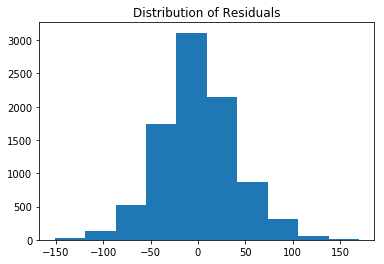

In [54]:
# Are residuals normally distributed?
plt.hist(work_results['residual'])
plt.title('Distribution of Residuals')
plt.show()

Though it is ever so slightly skewed, the residuals are normal enough.

## Evenly distributed Residuals amoung Parameters

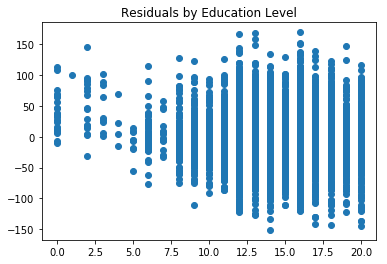

In [55]:
# Is variance constant for all values of the predictors?
plt.scatter(work_results['Educ'],work_results['residual'])
plt.title('Residuals by Education Level')
plt.show()

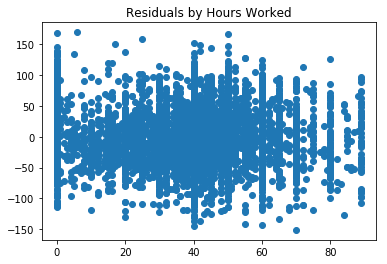

In [56]:
# Is variance constant for all values of the predictors?
plt.scatter(work_results['Hours'],work_results['residual'])
plt.title('Residuals by Hours Worked')
plt.show()

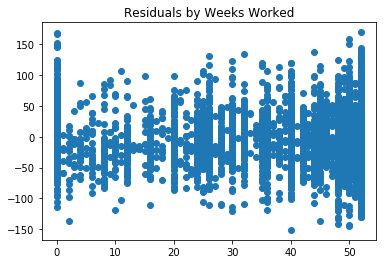

In [57]:
# Is variance constant for all values of the predictors?
plt.scatter(work_results['Weeks'],work_results['residual'])
plt.title('Residuals by Weeks Worked')
plt.show()

The week residuals are slightly heteroscedastic, but not by that much. They earlier education values have more negative errors, while most of the other values have an equal distribution.

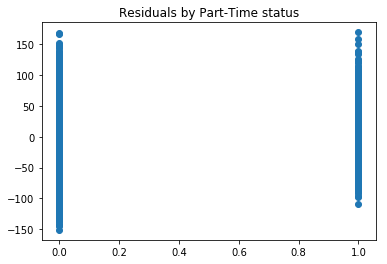

In [58]:
# Is variance constant for all values of the predictors?
plt.scatter(work_results['Part'],work_results['residual'])
plt.title('Residuals by Part-Time status')
plt.show()

This looks great too. There is a little inconsistency in the education level residuals, but overall both features seem pretty balanced.

## Homoscedastic Residuals

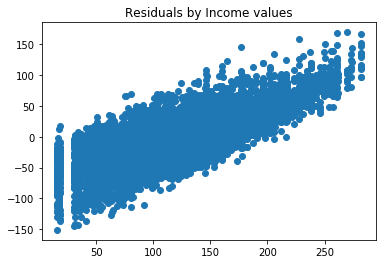

In [59]:
# Is variance constant for all values of the outcome?
plt.scatter(work_results['Target'],work_results['residual'])
plt.title('Residuals by Income values')
plt.show()

Unfortunately, my model is very heteroscadastic about the outcome. I did much to try and remedy this, include the performed square root transformations, to features transformation and selection sets I tried behind the scenes.

# Interpreting Model Results

In [60]:
print(riret_result.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Target     
No. Observations:   8929      Method:               REML       
No. Groups:         72        Scale:                1626.4969  
Min. group size:    1         Likelihood:           -45772.9253
Max. group size:    270       Converged:            Yes        
Mean group size:    124.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         16.118    2.685   6.004 0.000  10.856  21.380
Educ               5.068    0.222  22.866 0.000   4.634   5.503
Hours              0.540    0.025  21.529 0.000   0.490   0.589
Weeks              0.624    0.030  21.122 0.000   0.566   0.682
Part             -40.326    1.712 -23.557 0.000 -43.681 -36.971
Group Var         31.100    1.626                    

The best fitting model configuration, __Random Intercept, Random Education and Part-Time Slope__, gives me this linear equation:

$$\sqrt{Income_{a}} = 16.118+G_{a} + (5.068+GE_{a}) * E + 0.540 * H + 0.624 * W + (-40.326+GP_{a}) * P $$

where $Income_{a}$ is equal to Income given age, $G_{a}$ is the change in intercept given age, $GE_{a}$ is the education coefficinet change given age, $E$ is education level, $H$ is hours worked per week, $W$ is weeks worked per year, $GP_{a}$ is the Part-Time coefficient change given age, and $P$ is if the respondant is a part-time worker.

Skipping past the intercept for now, I'll look at Education level. It has a value of around 5.1, meaning that the square root of an average erson's income will go up by 5.1 for each additional year of education they complete. Education has a tiny group variance, only being 1/5 the value of the coefficent itself and having a very low standard error. Out of all the random effects, the effect of education of the square root of income is the least variable with age.

An average person's square root income will go up by 0.5 for each addional hour per week they work.

An average person's square root income will go up by 0.6 for each additional week per year they work.

An average person who works part-time will have a square root income that is 40.3 less than someone who is not a part-time worker. This distrinction is key, as there are more than just full-time workers that are not part-time workers. This has a very large group variance, being almost doulbe the actual coefficient value. This means that the way that being a part-time worker affects a person's square root income is very affected by their age.

Coming back to the intercept, the base starting point for square root income is 16.1. Because of how categorical variables function in a linear model, this has become the value representing people who are not part-time workers, have 0 years of education, 0 hours of work, and are not part-time workers. These could be full-time workers, retiree pension earners, trust-funders, etc. So, the average person who has no education, or work hours has an income of $16.1^{2}$, or \$259.21. Just by being a part-time worker, the average person starts at an income of $-24.2^{2}$, or \$-585.64, and must make it up through some combination of education and time worked.

It has a much higher standard errer, only being 1/8 the size of the intercept value. This is probably due to it containing so many different types of earners within the non-part-time workers group. The random intercept, called "Group", is also very large, being twice as large as the intercept itself. This tells me that the base income varies widely for different ages.

This means that all of these affects have a quadratic affect on the income, each factors afftects a person more the more income the have. This is especially troubling news for the average people working part-time, as it means that much of their education and work time is put into just getting into a positive income from the initial hit they take.

# Conclusions

Being a part time worker in America is an enormous detriment to Income. Two people with equal education and time spent working will have very different income values.

Additionally, the way that education level and being a part-time worker affect income change drastically with a persons age, significantly more than any change in way hours and weeks worked affect income.  The based income a person can have changes drastically as well.

This is shown in the real world, as the younger of 2 workers with the same credentials will usually be the seen as the one who is less valuable due to less experiance, and thus paid less. Conversely, older people who no longer work with equal credentials to people who do work will earner less because their income has been scaled back based on their retirement plans.

My model had some errors which could be addressed in future researched. A linear mixed effect model may not be the most ideal model to use for an Income outcome variable, but it was the scope of my project. In the future, I may attempt to use a Pareto distribution based model and try to account for age in another way.